In [13]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
import random
import copy

In [14]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
    
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()  # 順にnn, no, on, oo
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
    
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ### パーティクルの位置と地図からランドマークの位置と方角を算出
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ### 尤度の計算
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

In [31]:
class Mcl:
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                distance_dev_rate=0.14, direction_dev=0.05):
        self.particles =  [ Particle(init_pose, 1.0 / num) for i in range(num) ]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
        self.ml = self.particles[0]
        self.pose = self.ml.pose
    
    def set_ml(self):
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
    
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
        self.set_ml()
        self.resampling()
    
    # 完全にランダムでサンプリングする方法
    # 計算量: O(n log n)
    # サンプリングバイアスが生じる可能性がある
    def resampling_random_choice(self):
        ws = [e.weight for e in self.particles]
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]  # 重みの和がゼロに丸め込まれるとエラーになるので回避
        ps = random.choices(self.particles, weights=ws, k=len(self.particles))  # wsの要素に比例した確率で，パーティクルをnum個選ぶ
        self.particles = [copy.deepcopy(e) for e in ps]  # 選んだリストからパーティクルを取り出し，重みを均一に
        for p in self.particles:
            p.weight = 1.0/len(self.particles)  # 重みの正規化（均一にする）
    
    # 系統サンプリング
    # 計算量: O(n)
    # ランダムに選ばないので偏りは生じにくい
    def resampling(self):
        ws = np.cumsum([e.weight for e in self.particles])  # 重みを累積して足していく
        if ws[-1] < 1e-100: ws = [e+1e-100 for e in ws]  # 重みの合計が0の時の処理
        
        step = ws[-1]/len(self.particles)  # 正規化されていない場合はステップが「重みの合計値/N」になる
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []  # 抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1
        
        self.particles = [copy.deepcopy(e) for e in ps]
        for p in self.particles:
            p.weight = 1.0/len(self.particles)
    
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) * p.weight * len(self.particles) for p in self.particles]
        vys = [math.sin(p.pose[2]) * p.weight * len(self.particles) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5))

In [32]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose
        s = "({:.2f}, {:2f}, {})".format(x, y, int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))

In [33]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 100)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    ### アニメーション実行 ###
    world.draw()

<IPython.core.display.Javascript object>


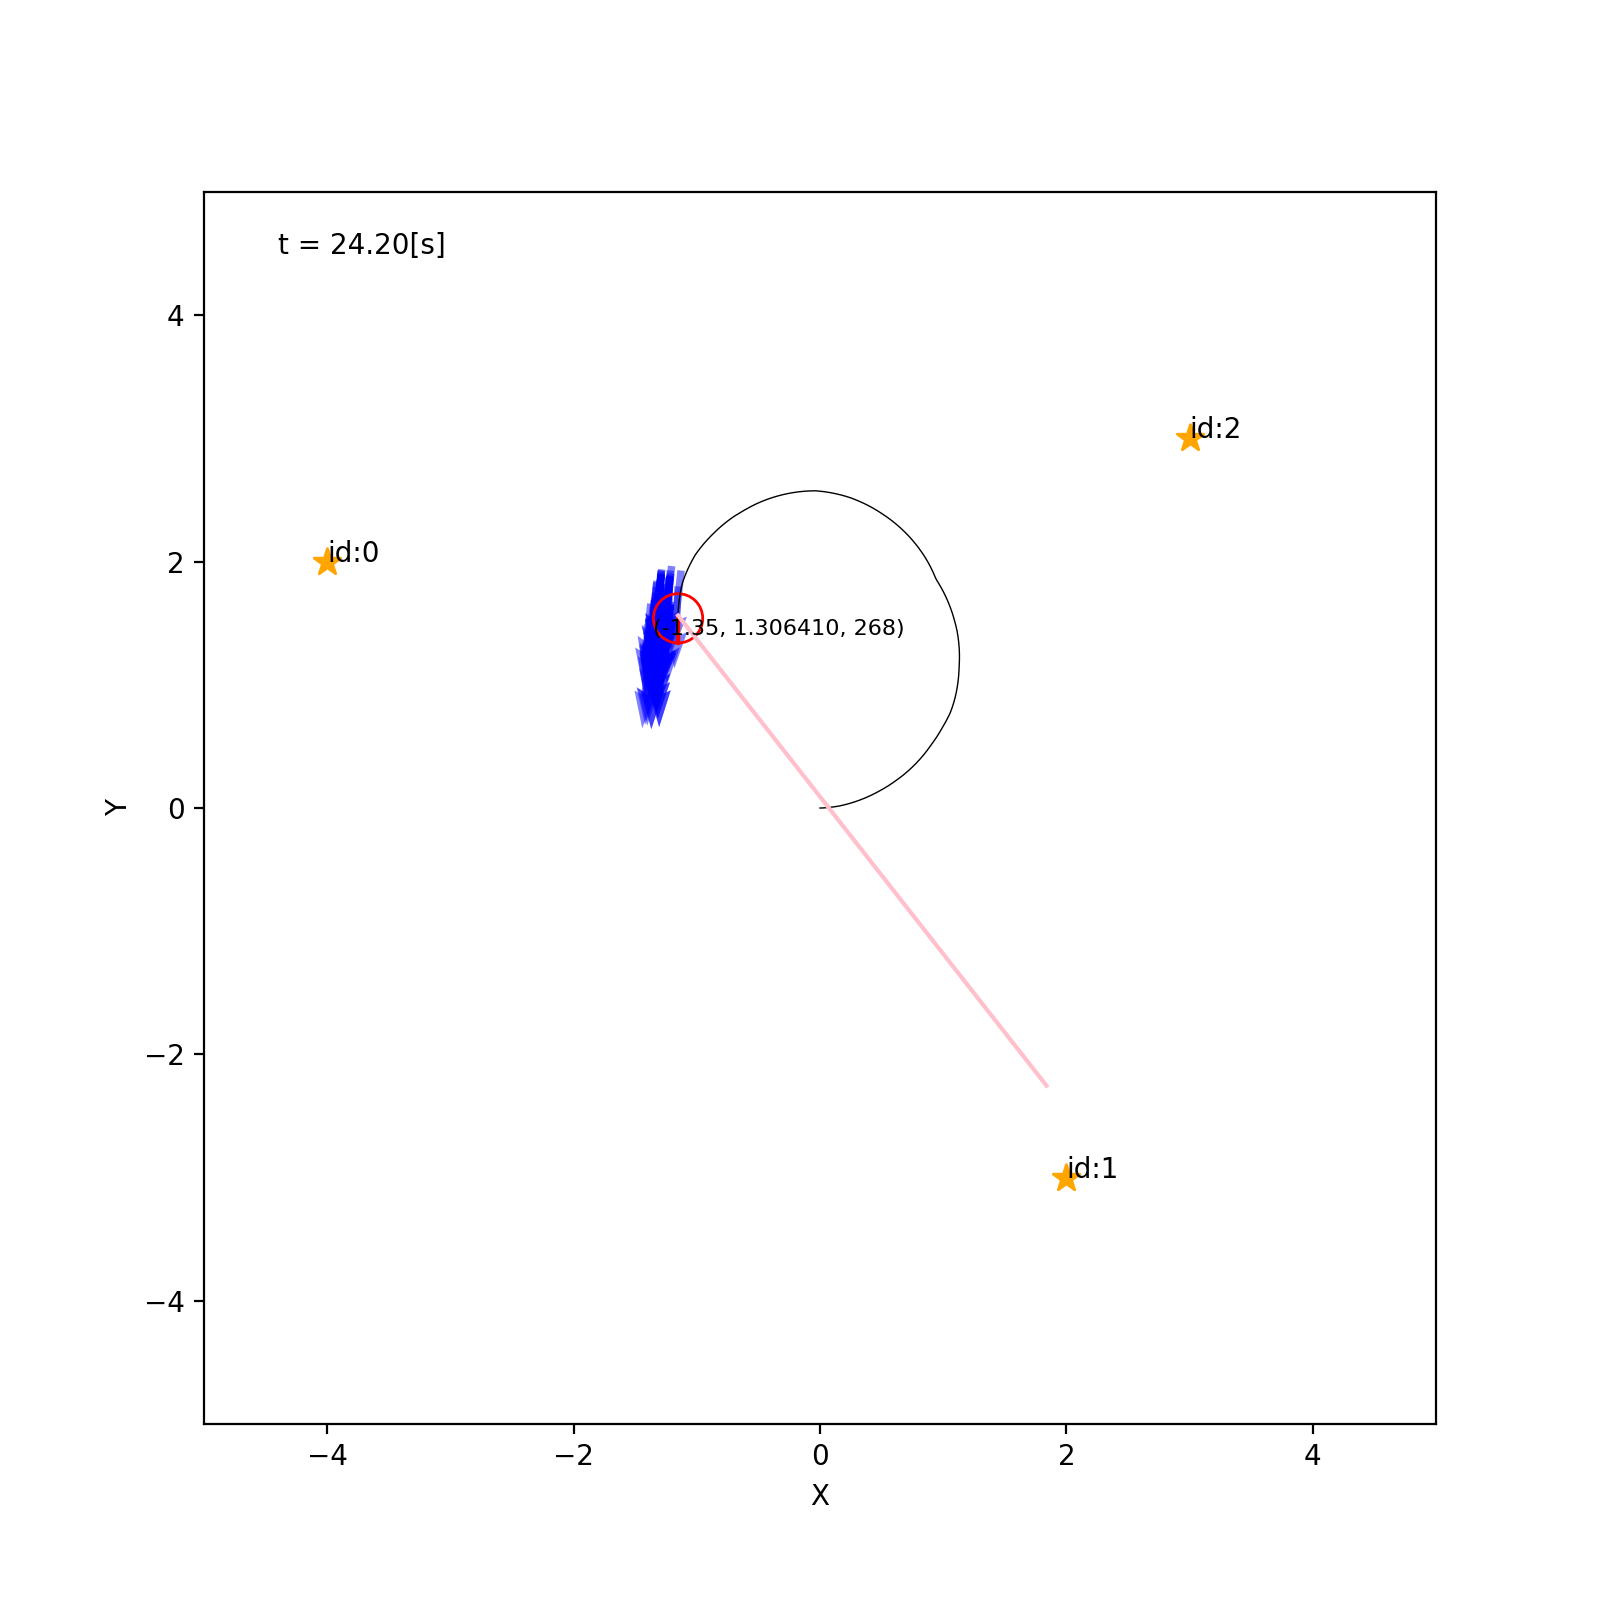

In [34]:
trial()

In [ ]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no": 0.02, "on": 0.03, "oo":0.04})
a = EstimationAgent(0.1, 0.2, 10.0/180*math.pi, estimator)
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)